In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import json
import itertools
from scipy.stats import linregress
import plotly_express as px
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import math
import seaborn as sns
from scipy.signal import savgol_filter

from collections.abc import Callable
import numpy as np
import torch
from datasets import Dataset, load_dataset
from typing import Optional, Tuple
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import final, cast
import pickle
import gc
from scipy.stats import kstest

## Setup

In [2]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_ref, logprobs_pert, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")


def get_random_activations(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos, n_samples
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompts = torch.cat(
        [generate_prompt(dataset, n_ctx=n_ctx) for _ in range(n_samples)]
    )
    _, cache = model.run_with_cache(rand_prompts)
    return cache[layer][:, pos, :].to("cpu").detach()


def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


def setup_random_sampling_data_cov():
    data_mean = torch.tensor(np.load("observations_layer1/data_mean.npy"))
    data_cov = torch.tensor(np.load("observations_layer1/data_cov.npy"))
    distrib = MultivariateNormal(data_mean, data_cov)
    return distrib

In [3]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [4]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=111,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [5]:
set_seed(cfg.seed)

In [6]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [7]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [8]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[cfg.perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Visualisations

In [9]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def get_random_acts(distrib, k=1):
    return distrib.sample([k])


def synthetic_perturbation_homeschooled_v2(sae, start_act):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()
    top_active_feature_id = feature_acts.argsort()[-1]
    mean_sim_base_target = 0.42

    spars_scores = abs(feature_sparsities - feature_sparsities[top_active_feature_id])
    spars_scores[top_active_feature_id] = torch.inf

    candidate_feat_ids = spars_scores.argsort()[:100]

    sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[candidate_feat_ids]
        )
        .detach()
        .cpu()
    )
    candidate_feat_id = candidate_feat_ids[
        abs(sims - mean_sim_base_target).argsort()[0]
    ]

    candidate_sims = (
        F.cosine_similarity(sae.W_dec[candidate_feat_id], sae.W_dec).detach().cpu()
    )
    top_feat_sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[active_feature_ids]
        )
        .detach()
        .cpu()
    )

    candidate_feature_ids = []
    candidate_feature_acts = []

    for i, f_id in enumerate(active_feature_ids):
        feat_cos_sim = top_feat_sims[i]
        feat_act = feature_acts[f_id]
        _, candidate_feat_ids = abs(candidate_sims - feat_cos_sim).sort()

        for cf_id in candidate_feat_ids:
            if cf_id in candidate_feature_ids:
                continue

            candidate_feature_ids.append(cf_id.item())
            candidate_feature_acts.append(feat_act.item())
            break

    target_feature_acts = torch.zeros(sae.W_dec.shape[0])
    target_feature_acts[candidate_feature_ids] = torch.tensor(candidate_feature_acts)

    end_act = sae.decode(target_feature_acts).to(device)
    return end_act

In [10]:
distrib = setup_random_sampling_data_cov()
non_dead_feat_ids = np.where(sparsities[cfg.perturbation_layer].cpu().numpy() > -10)[0]

In [11]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 10

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [12]:
norms = []

for acts in activations:
    norms.append(sae.encode(torch.tensor(acts[0])).norm().item())

mean_norm_sae = np.mean(norms)
print(mean_norm_sae)

25.931307791233063


In [94]:
idxs = random.sample(range(len(metadata)), 100)

start_acts = []
start_prompts = []

other_acts = []
random_acts = []
synth_acts = []

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    steps = m["steps_metadata"]
    prompt = torch.tensor(m["start_prompt"])
    start_act = torch.tensor(acts[0]).to(device)
    start_acts.append(start_act)

    start_prompts.append(prompt)

    # Synthetic as T
    end_act = synthetic_perturbation_homeschooled_v2(sae, start_act)
    synth_acts.append(end_act)
    # --------------------------------------------------------------------------

    # Other Act as T
    end_act = torch.tensor(acts[-1]).to(device)
    other_acts.append(end_act)
    # --------------------------------------------------------------------------

    # Random as T
    end_act = get_random_acts(distrib).squeeze(0).to(device)
    random_acts.append(end_act)
    # --------------------------------------------------------------------------

In [14]:
# import pickle

# results = {
#     'start_acts': torch.stack(start_acts).detach().cpu().numpy(),
#     'other_acts': torch.stack(other_acts).detach().cpu().numpy(),
#     'random_acts': torch.stack(random_acts).detach().cpu().numpy(),
#     'synth_acts': torch.stack(synth_acts).detach().cpu().numpy()
# }

# with open('data/visualisation_acts.pkl', 'wb') as fw:
#     pickle.dump(results, fw)

In [14]:
# import pickle

# with open('data/visualisation_acts.pkl', 'rb') as fr:
#     results = pickle.load(fr)

# all_start_acts = results['start_acts']
# all_other_acts = results['other_acts']
# all_random_acts = results['random_acts']
# all_synth_acts = results['synth_acts']

### PCA Visualisations

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [16]:
def plot_projections(data, labels, title, class_names):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=18)

    projection_methods = [
        ("PCA", PCA(n_components=2)),
        ("t-SNE", TSNE(n_components=2, random_state=42)),
        ("UMAP", umap.UMAP()),
    ]

    for i, (method_name, method) in enumerate(projection_methods):
        result = method.fit_transform(data)
        scatter = axs[i].scatter(result[:, 0], result[:, 1], c=labels)
        axs[i].set_title(method_name, fontsize=14)
        axs[i].set_xlabel("Component 1")
        axs[i].set_ylabel("Component 2")

        # Add legend
        legend1 = axs[i].legend(
            scatter.legend_elements()[0],
            class_names,
            loc="upper right",
            title="Classes",
        )
        axs[i].add_artist(legend1)

    plt.tight_layout()
    plt.show()

In [17]:
all_other_acts = torch.stack(other_acts).detach().cpu().numpy()
all_random_acts = torch.stack(random_acts).detach().cpu().numpy()
all_synth_acts = torch.stack(synth_acts).detach().cpu().numpy()

In [18]:
n_samples = len(idxs)
all_activations = np.vstack((all_other_acts, all_random_acts, all_synth_acts))
labels = np.concatenate(
    (np.zeros(n_samples), np.ones(n_samples), 2 * np.ones(n_samples))
)

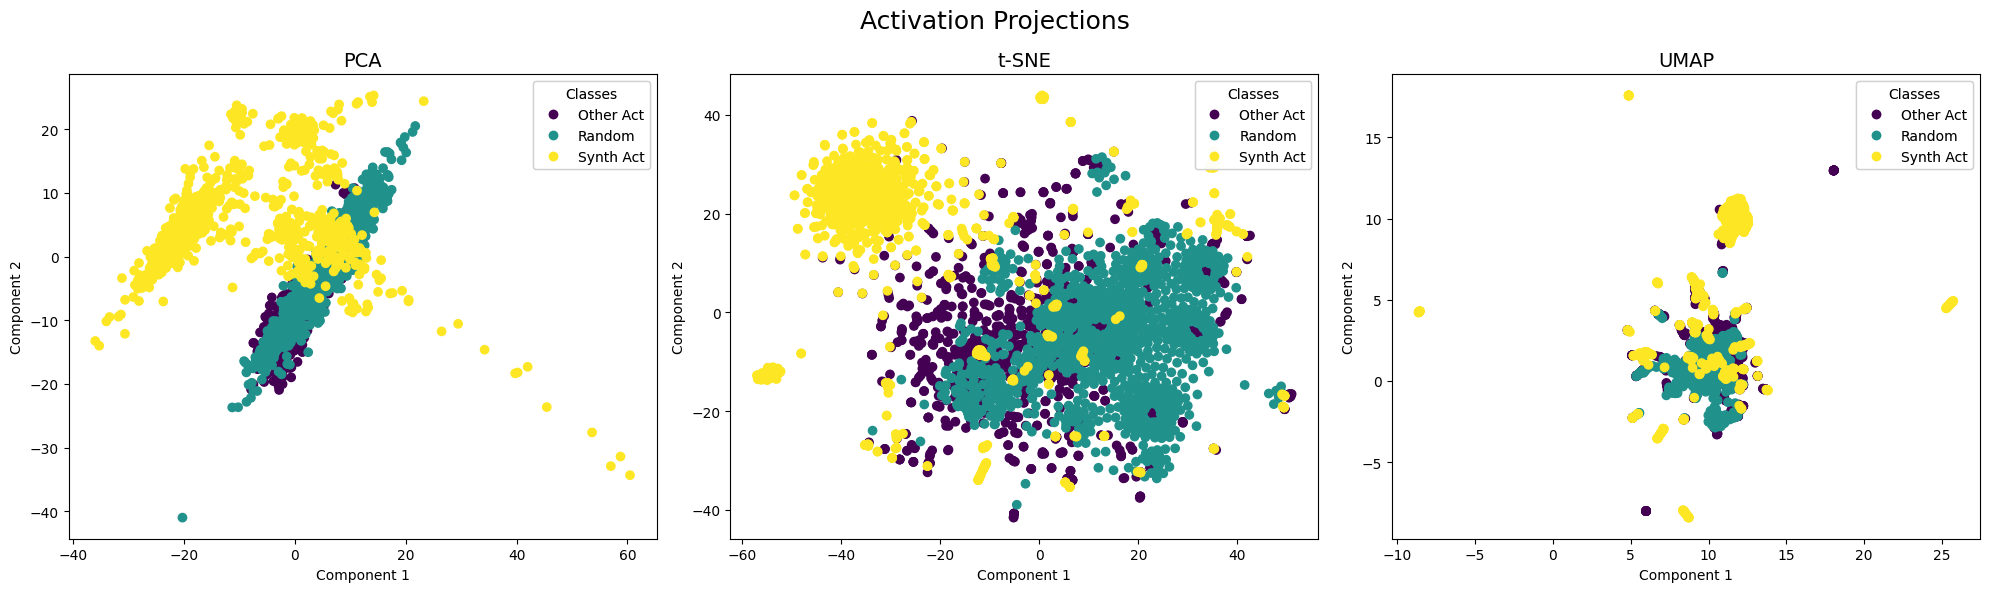

In [19]:
# Define human-friendly class names
class_names = ["Other Act", "Random", "Synth Act"]

# Plot projections
plot_projections(all_activations, labels, "Activation Projections", class_names)

### Distance from mean

In [20]:
mean_act = np.concatenate([activations[:, 0, :], activations[:, -1, :]]).mean(axis=0)

In [21]:
other_mean_diff = all_other_acts - mean_act
random_mean_diff = all_random_acts - mean_act
synth_mean_diff = all_synth_acts - mean_act

In [22]:
def compare_activations(acts_list, mean_act, class_names):
    """
    Compare activations using pre-computed mean activation.

    :param activations_list: List of activation arrays
    :param mean_act: Pre-computed mean activation
    :param class_names: List of names for each activation type
    """
    # Plot histogram of L2 distances
    fig, ax = plt.subplots(figsize=(12, 6))

    data = [np.sqrt(np.sum((act - mean_act) ** 2, axis=1)) for act in acts_list]

    all_data = np.concatenate(data)
    bins = np.linspace(all_data.min(), all_data.max(), 30)

    for l2_dists, name in zip(data, class_names):
        # Plot histogram of L2 distances
        ax.hist(l2_dists, bins=bins, alpha=0.7, label=name)

    ax.set_title("Histogram of L2 Distances from Resid Mean")
    ax.set_xlabel("L2 Distance")
    ax.set_ylabel("Frequency")
    ax.legend()

    plt.tight_layout()
    plt.show()

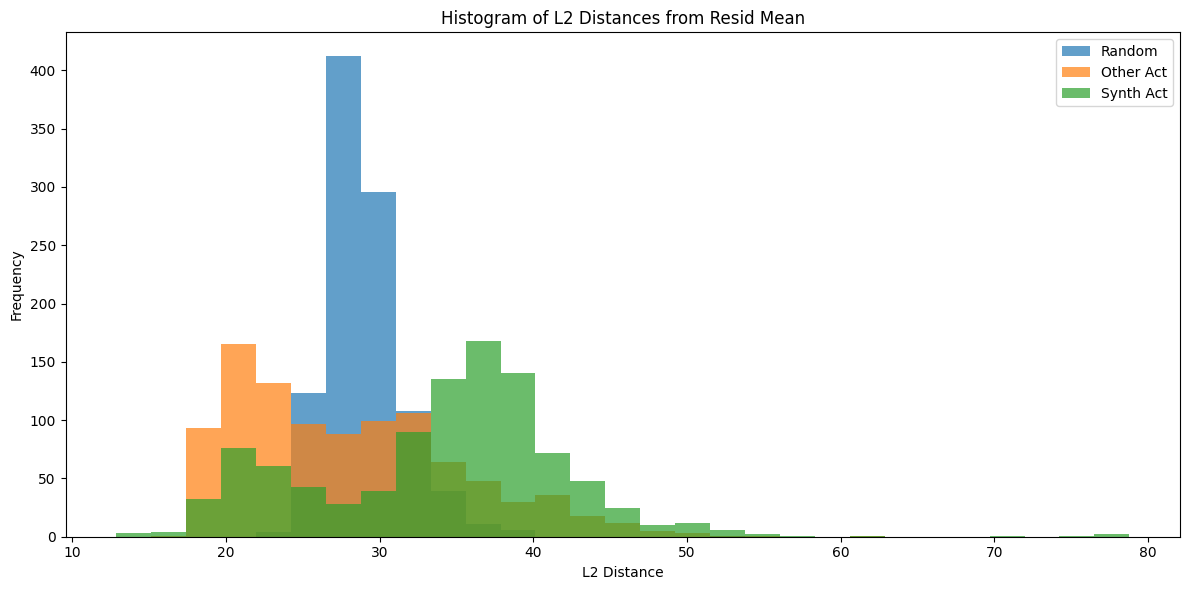

In [23]:
acts_list = [all_random_acts, all_other_acts, all_synth_acts]

class_names = ["Random", "Other Act", "Synth Act"]

compare_activations(acts_list, mean_act, class_names)

### Activation Plateaus (around other-act, random & synth)

In [25]:
def run_with_perturbation(cfg, model, prompt, perturbed_acts):
    def hook(act, hook):
        act[:, -1, :] = perturbed_acts

    prompts = prompt.repeat(perturbed_acts.shape[0], 1)

    with model.hooks(fwd_hooks=[(cfg.perturbation_layer, hook)]):
        logits_pert, cache = model.run_with_cache(prompts)

    return logits_pert, cache


def get_l2_norms(cache, cfg):
    read_layer_l2_norms = (
        torch.norm(
            cache[cfg.read_layer][:, -1, :] - cache[cfg.read_layer][0, -1, :],
            dim=1,
        )
        .detach()
        .cpu()
    )
    return read_layer_l2_norms

In [26]:
from scipy.stats import ortho_group

In [28]:
def generate_orthogonal_directions(dim=768):
    """
    Generate a set of orthogonal directions.

    :param dim: Dimensionality of the activation space
    :return: Array of orthogonal directions
    """
    return ortho_group.rvs(dim)


def perturb_activation_multi_direction(
    start_act, directions, step_size=0.5, num_steps=100
):
    """
    Perturb activation from start_act along multiple given directions.

    :param start_act: Starting activation (shape: [hidden_size])
    :param directions: Tensor of directions to perturb along (shape: [num_directions, hidden_size])
    :param step_size: Size of each step in the perturbation
    :param num_steps: Number of steps for perturbation
    :return: Tensor of perturbed activations
    """
    device = start_act.device
    num_directions = directions.shape[0]

    # Normalize directions
    directions = directions / directions.norm(dim=1, keepdim=True)

    # Create steps
    t = (
        torch.linspace(0, num_steps - 1, num_steps, device=device)
        .unsqueeze(0)
        .unsqueeze(2)
    )

    # Broadcast start_act and create perturbations
    start_act_expanded = (
        start_act.unsqueeze(0).unsqueeze(0).expand(num_directions, num_steps, -1)
    )
    perturbations = start_act_expanded + directions.unsqueeze(1) * t * step_size

    return perturbations

In [29]:
directions = torch.tensor(generate_orthogonal_directions())

l2_dists = []

acts = all_other_acts[0]
prompt = start_prompts[0]

T = torch.tensor(acts)
perturbations = perturb_activation_multi_direction(T, directions)

for pert in perturbations:
    pert_logits, cache = run_with_perturbation(cfg, model, prompt, pert)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    l2_dists.append(read_layer_l2_norms)


l2_dists = np.array(l2_dists)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans


def visualize_l2_distances_advanced(l2_distances):
    """
    Visualize L2 distances using advanced techniques.

    :param l2_distances: L2 distances tensor of shape (num_directions, num_steps)
    """
    num_directions, num_steps = l2_distances.shape

    # 1. Sort directions based on L2 distance profiles
    sorted_indices = np.argsort(l2_distances.sum(axis=1))
    sorted_l2_distances = l2_distances[sorted_indices]

    # plt.figure(figsize=(12, 8))
    plt.imshow(sorted_l2_distances, aspect="auto", cmap="jet")
    plt.colorbar(label="L2 Distance")
    plt.title("Sorted Heatmap of L2 Distances")
    plt.xlabel("Steps")
    plt.ylabel("Sorted Directions")
    plt.show()

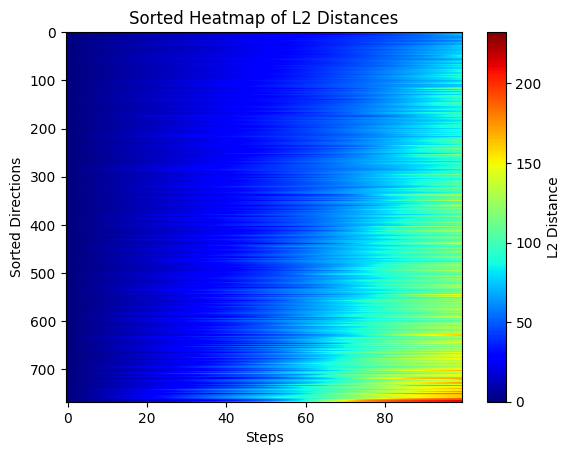

In [44]:
visualize_l2_distances_advanced(l2_dists)

## 2-D Plane Experiment

In [99]:
def linear_interpolation(A, B, alpha):
    return A + alpha * (B - A)


def calculate_P(A, B, M):
    pert_direction = B - A
    a_to_mean_direction = M - A
    t = np.dot(a_to_mean_direction, pert_direction) / np.dot(
        pert_direction, pert_direction
    )
    t = max(0, min(1, t))  # Clamp t between 0 and 1
    return linear_interpolation(A, B, t)


def run_with_perturbation(cfg, model, prompt, perturbed_acts):
    def hook(act, hook):
        act[:, -1, :] = perturbed_acts

    prompts = prompt.repeat(perturbed_acts.shape[0], 1)

    with model.hooks(fwd_hooks=[(cfg.perturbation_layer, hook)]):
        logits_pert, cache = model.run_with_cache(prompts)

    return logits_pert, cache


def get_l2_norms(cache, cfg):
    read_layer_l2_norms = (
        torch.norm(
            cache[cfg.read_layer][:, -1, :] - cache[cfg.read_layer][0, -1, :],
            dim=1,
        )
        .detach()
        .cpu()
    )
    return read_layer_l2_norms


def generate_2d_interpolation(A, B, M, prompt, n_alpha=10, n_beta=10):
    # alpha_range = np.linspace(0, 1, n_alpha)
    # beta_range = np.linspace(-1, 1, n_beta)
    alpha_range = np.linspace(-1, 2, n_alpha)
    beta_range = np.linspace(-2, 2, n_beta)
    batch_size = 100

    P = calculate_P(A, B, M)

    # A to B direction
    all_perturbed_acts = []

    for beta in beta_range:
        for alpha in alpha_range:
            inter_AB = linear_interpolation(A, B, alpha) + beta * (P - M)
            all_perturbed_acts.append(inter_AB)

    all_perturbed_acts = torch.tensor(np.stack(all_perturbed_acts)).to(device)

    all_l2_norms = []

    for batch in torch.split(all_perturbed_acts, batch_size):
        _, cache = run_with_perturbation(cfg, model, prompt, batch)
        batch_l2_norms = get_l2_norms(cache, cfg)
        all_l2_norms.append(batch_l2_norms)
        torch.cuda.empty_cache()

    all_l2_norms = torch.cat(all_l2_norms)

    # _, cache = run_with_perturbation(cfg, model, prompt, all_perturbed_acts)
    # all_l2_norms = get_l2_norms(cache, cfg)

    distances_AB = all_l2_norms.reshape(n_beta, n_alpha)

    torch.cuda.empty_cache()

    # # Repeat for B to A direction
    # all_perturbed_acts = []

    # for beta in beta_range:
    #     for alpha in alpha_range:
    #         inter_BA = linear_interpolation(B, A, 1 - alpha) + beta * (P - M)
    #         all_perturbed_acts.append(inter_BA)

    # all_perturbed_acts = torch.tensor(np.stack(all_perturbed_acts)).to(device)

    # all_l2_norms = []

    # for batch in torch.split(all_perturbed_acts, batch_size):
    #     _, cache = run_with_perturbation(cfg, model, prompt, batch)
    #     batch_l2_norms = get_l2_norms(cache, cfg)
    #     all_l2_norms.append(batch_l2_norms)
    #     torch.cuda.empty_cache()

    # all_l2_norms = torch.cat(all_l2_norms)

    # _, cache = run_with_perturbation(cfg, model, prompt, all_perturbed_acts)
    # all_l2_norms = get_l2_norms(cache, cfg)

    # distances_BA = all_l2_norms.reshape(n_beta, n_alpha)

    # torch.cuda.empty_cache()

    return distances_AB, P


def plot_2d_interpolation(distances_AB, distances_BA, A, B, M, P, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    extent = [-1, 2, -2, 2]  # [0, 1, -1, 1]
    vmin, vmax = 0, np.max([distances_AB.max(), distances_BA.max()])

    for ax, distances, direction in [
        (ax1, distances_AB, "A to T"),
        (ax2, distances_BA, "T to A"),
    ]:
        im = ax.imshow(
            distances,
            aspect="auto",
            origin="lower",
            extent=extent,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_title(f"from {direction} - {title}")
        ax.set_xlabel("interpolation α")
        ax.set_ylabel("β")

        # Calculate x-coordinates for points
        M_x = np.dot(M - A, B - A) / np.dot(B - A, B - A)
        P_x = np.dot(P - A, B - A) / np.dot(B - A, B - A)

        # Add markers
        ax.plot(0 + 0.02, 0, "^", markersize=10, color="tab:green", label="A (base)")
        ax.plot(1 - 0.02, 0, "s", markersize=10, color="tab:blue", label="T (target)")
        ax.plot(P_x, 0, "x", markersize=10, color="tab:red", label="P")
        ax.plot(M_x, -1 + 0.03, "o", markersize=10, color="tab:red", label="mean")

        ax.legend(loc="upper right")
        plt.colorbar(im, ax=ax, label="L2 distance at Layer 11")

    plt.tight_layout()
    plt.show()


def plot_2d_interpolation_ab_subplots(plot_data):
    n_plots = len(plot_data)

    # Calculate optimal number of rows and columns
    n_cols = math.ceil(math.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows))
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    extent = [-1, 2, -2, 2]
    vmin, vmax = 0, np.max([data[0].max() for data in plot_data])

    for i, (distances_AB, A, B, M, P, title) in enumerate(plot_data):
        ax = axes[i]

        im = ax.imshow(
            distances_AB,
            aspect="auto",
            origin="lower",
            extent=extent,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_title(f"from A → B - {title}")
        ax.set_xlabel("interpolation α")
        ax.set_ylabel("β")

        # Calculate x-coordinates for points
        M_x = np.dot(M - A, B - A) / np.dot(B - A, B - A)
        P_x = np.dot(P - A, B - A) / np.dot(B - A, B - A)

        # Add markers
        ax.plot(0 + 0.02, 0, "^", markersize=10, color="tab:pink", label="A (base)")
        ax.plot(1 - 0.02, 0, "s", markersize=10, color="tab:cyan", label="T (target)")
        ax.plot(P_x, 0, "x", markersize=10, color="tab:red", label="P")
        ax.plot(M_x, -1 + 0.03, "o", markersize=10, color="tab:red", label="mean")

        ax.legend(loc="upper right")

        plt.colorbar(im, ax=ax, label="L2 distance at Layer 11")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


def plot_2d_interpolation_ab(distances_AB, A, B, M, P, title):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))  # width, height

    extent = [-1, 2, -2, 2]  # [0, 1, -1, 1]
    vmin, vmax = 0, np.max([distances_AB.max()])

    im = ax.imshow(
        distances_AB,
        aspect="auto",
        origin="lower",
        extent=extent,
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(f"from A → B - {title}")
    ax.set_xlabel("interpolation α")
    ax.set_ylabel("β")

    # Calculate x-coordinates for points
    M_x = np.dot(M - A, B - A) / np.dot(B - A, B - A)
    P_x = np.dot(P - A, B - A) / np.dot(B - A, B - A)

    # Add markers
    ax.plot(0 + 0.02, 0, "^", markersize=10, color="tab:green", label="A (base)")
    ax.plot(1 - 0.02, 0, "s", markersize=10, color="tab:blue", label="T (target)")
    ax.plot(P_x, 0, "x", markersize=10, color="tab:red", label="P")
    ax.plot(M_x, -1 + 0.03, "o", markersize=10, color="tab:red", label="mean")

    ax.legend(loc="upper right")
    plt.colorbar(im, ax=ax, label="L2 distance at Layer 11")

    plt.tight_layout()
    plt.show()


def run_experiment(
    start_acts, other_acts, mean_act, title, n_alpha=10, n_beta=10, n_examples=1
):
    random_idxs = random.sample(list(range(start_acts.shape[0])), n_examples)
    data = []

    for i in random_idxs:
        A = start_acts[i]
        B = other_acts[i]
        M = mean_act
        prompt = start_prompts[i]

        distances_AB, P = generate_2d_interpolation(
            A, B, M, prompt, n_alpha=n_alpha, n_beta=n_beta
        )
        data.append((distances_AB, A, B, M, P, f"{title} - Sample {i+1}"))

    plot_2d_interpolation_ab_subplots(data)

In [78]:
mean_act = np.concatenate([activations[:, 0, :], activations[:, -1, :]]).mean(axis=0)

all_other_acts = torch.stack(other_acts).detach().cpu().numpy()
all_random_acts = torch.stack(random_acts).detach().cpu().numpy()
all_synth_acts = torch.stack(synth_acts).detach().cpu().numpy()
all_start_acts = torch.stack(start_acts).detach().cpu().numpy()

In [91]:
all_start_acts.shape

(25, 768)

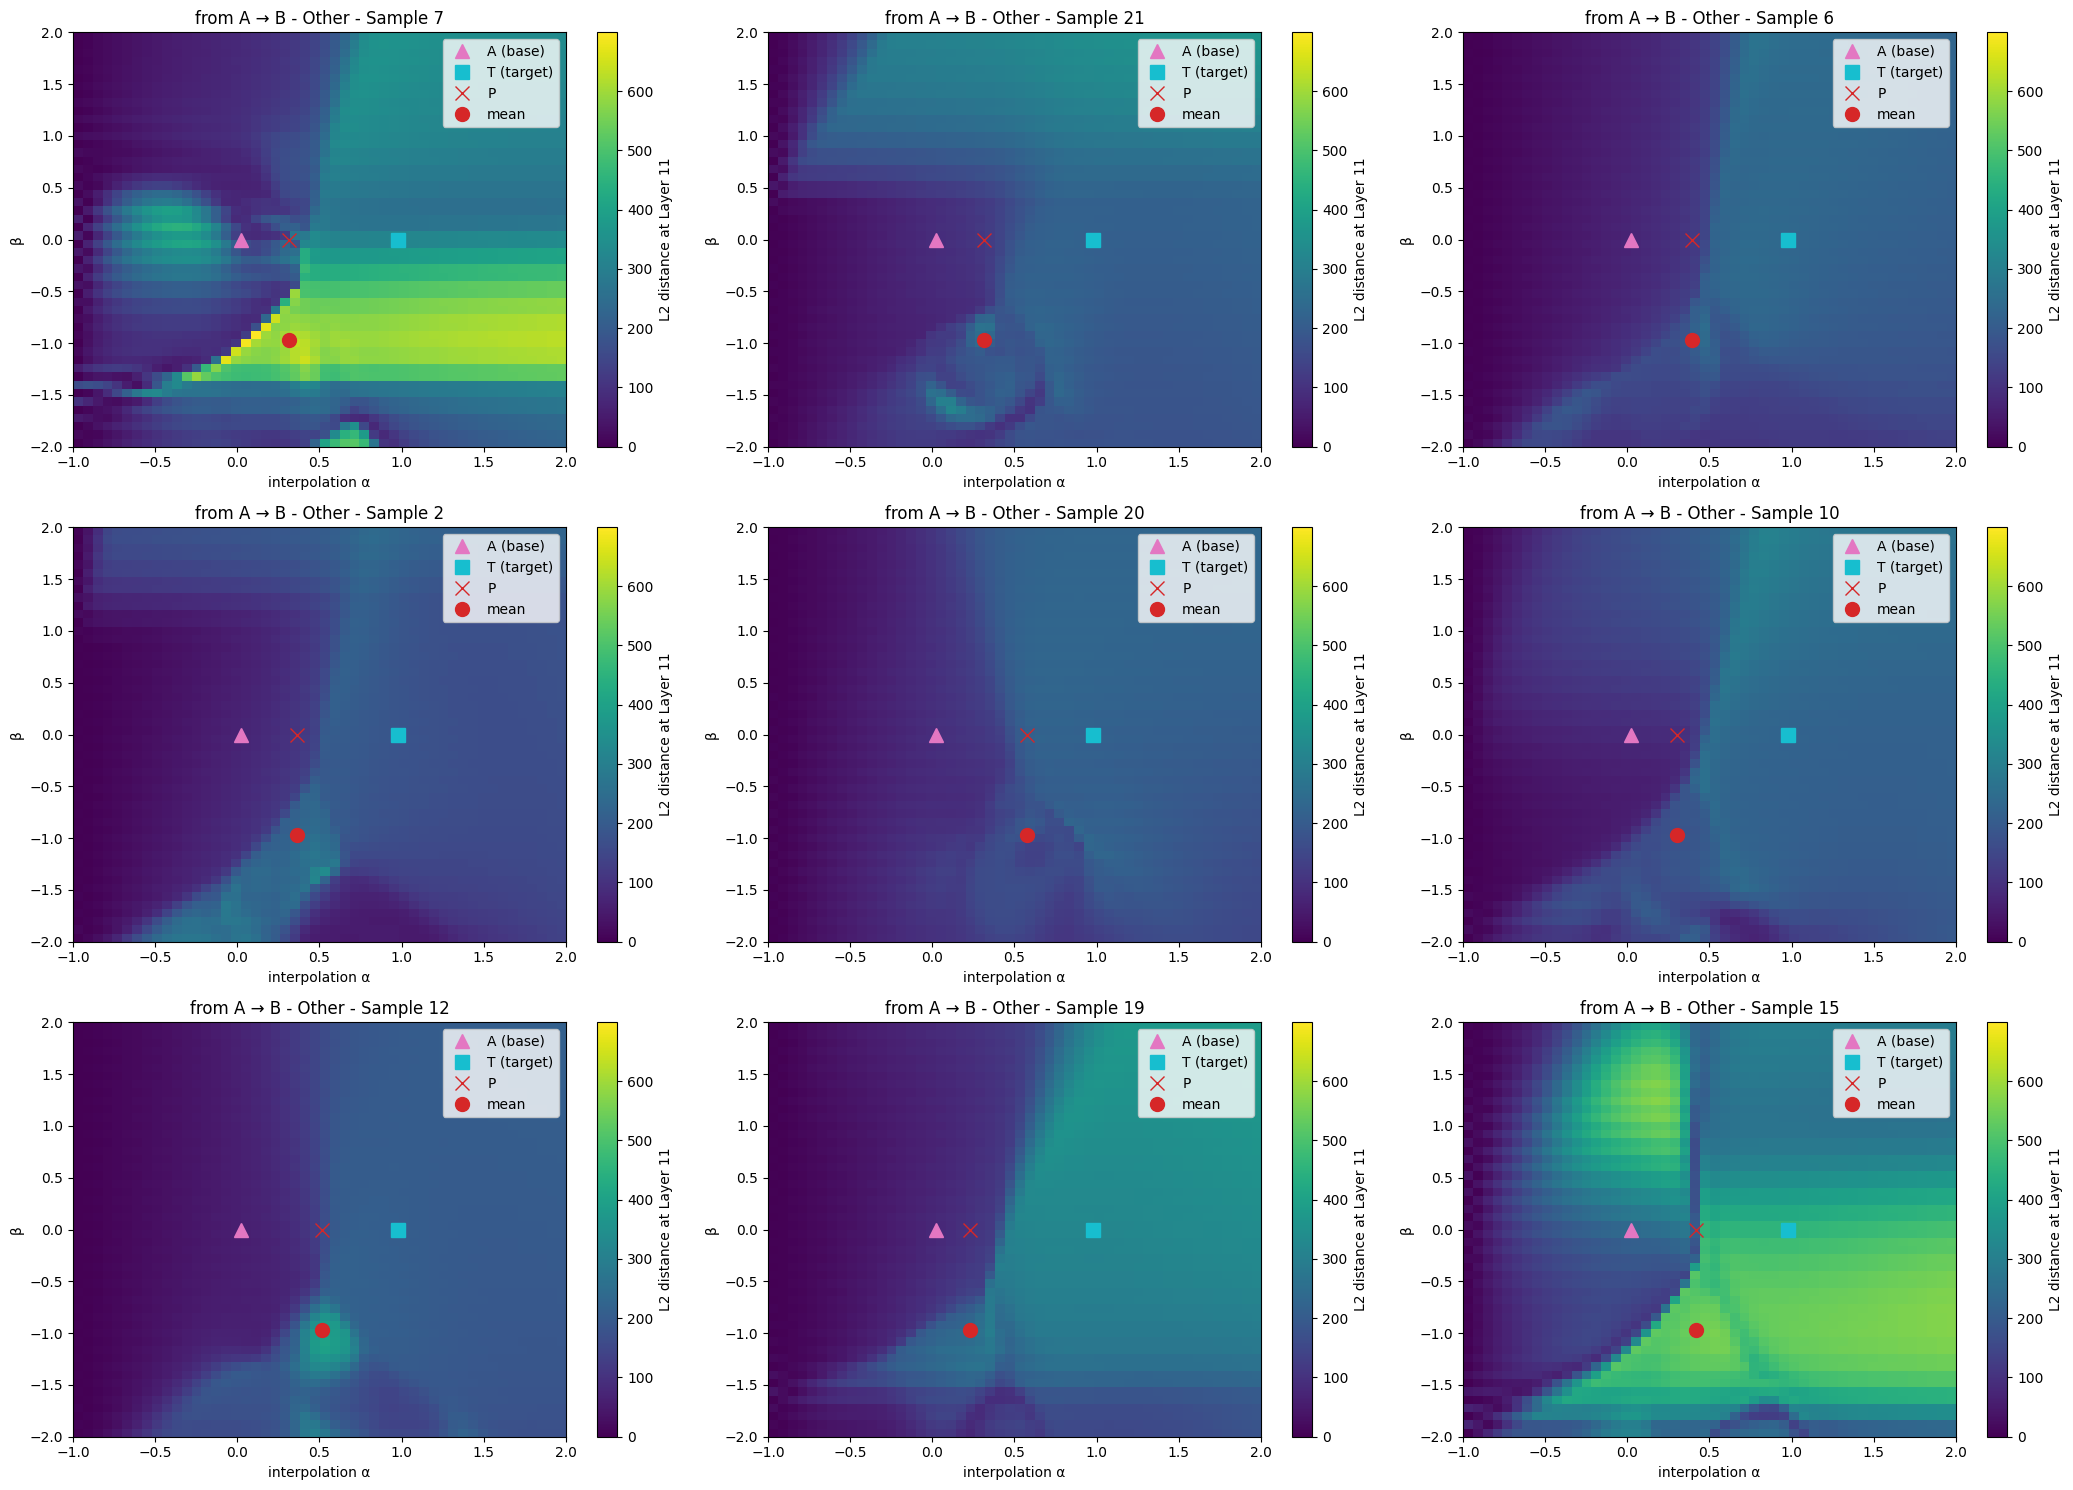

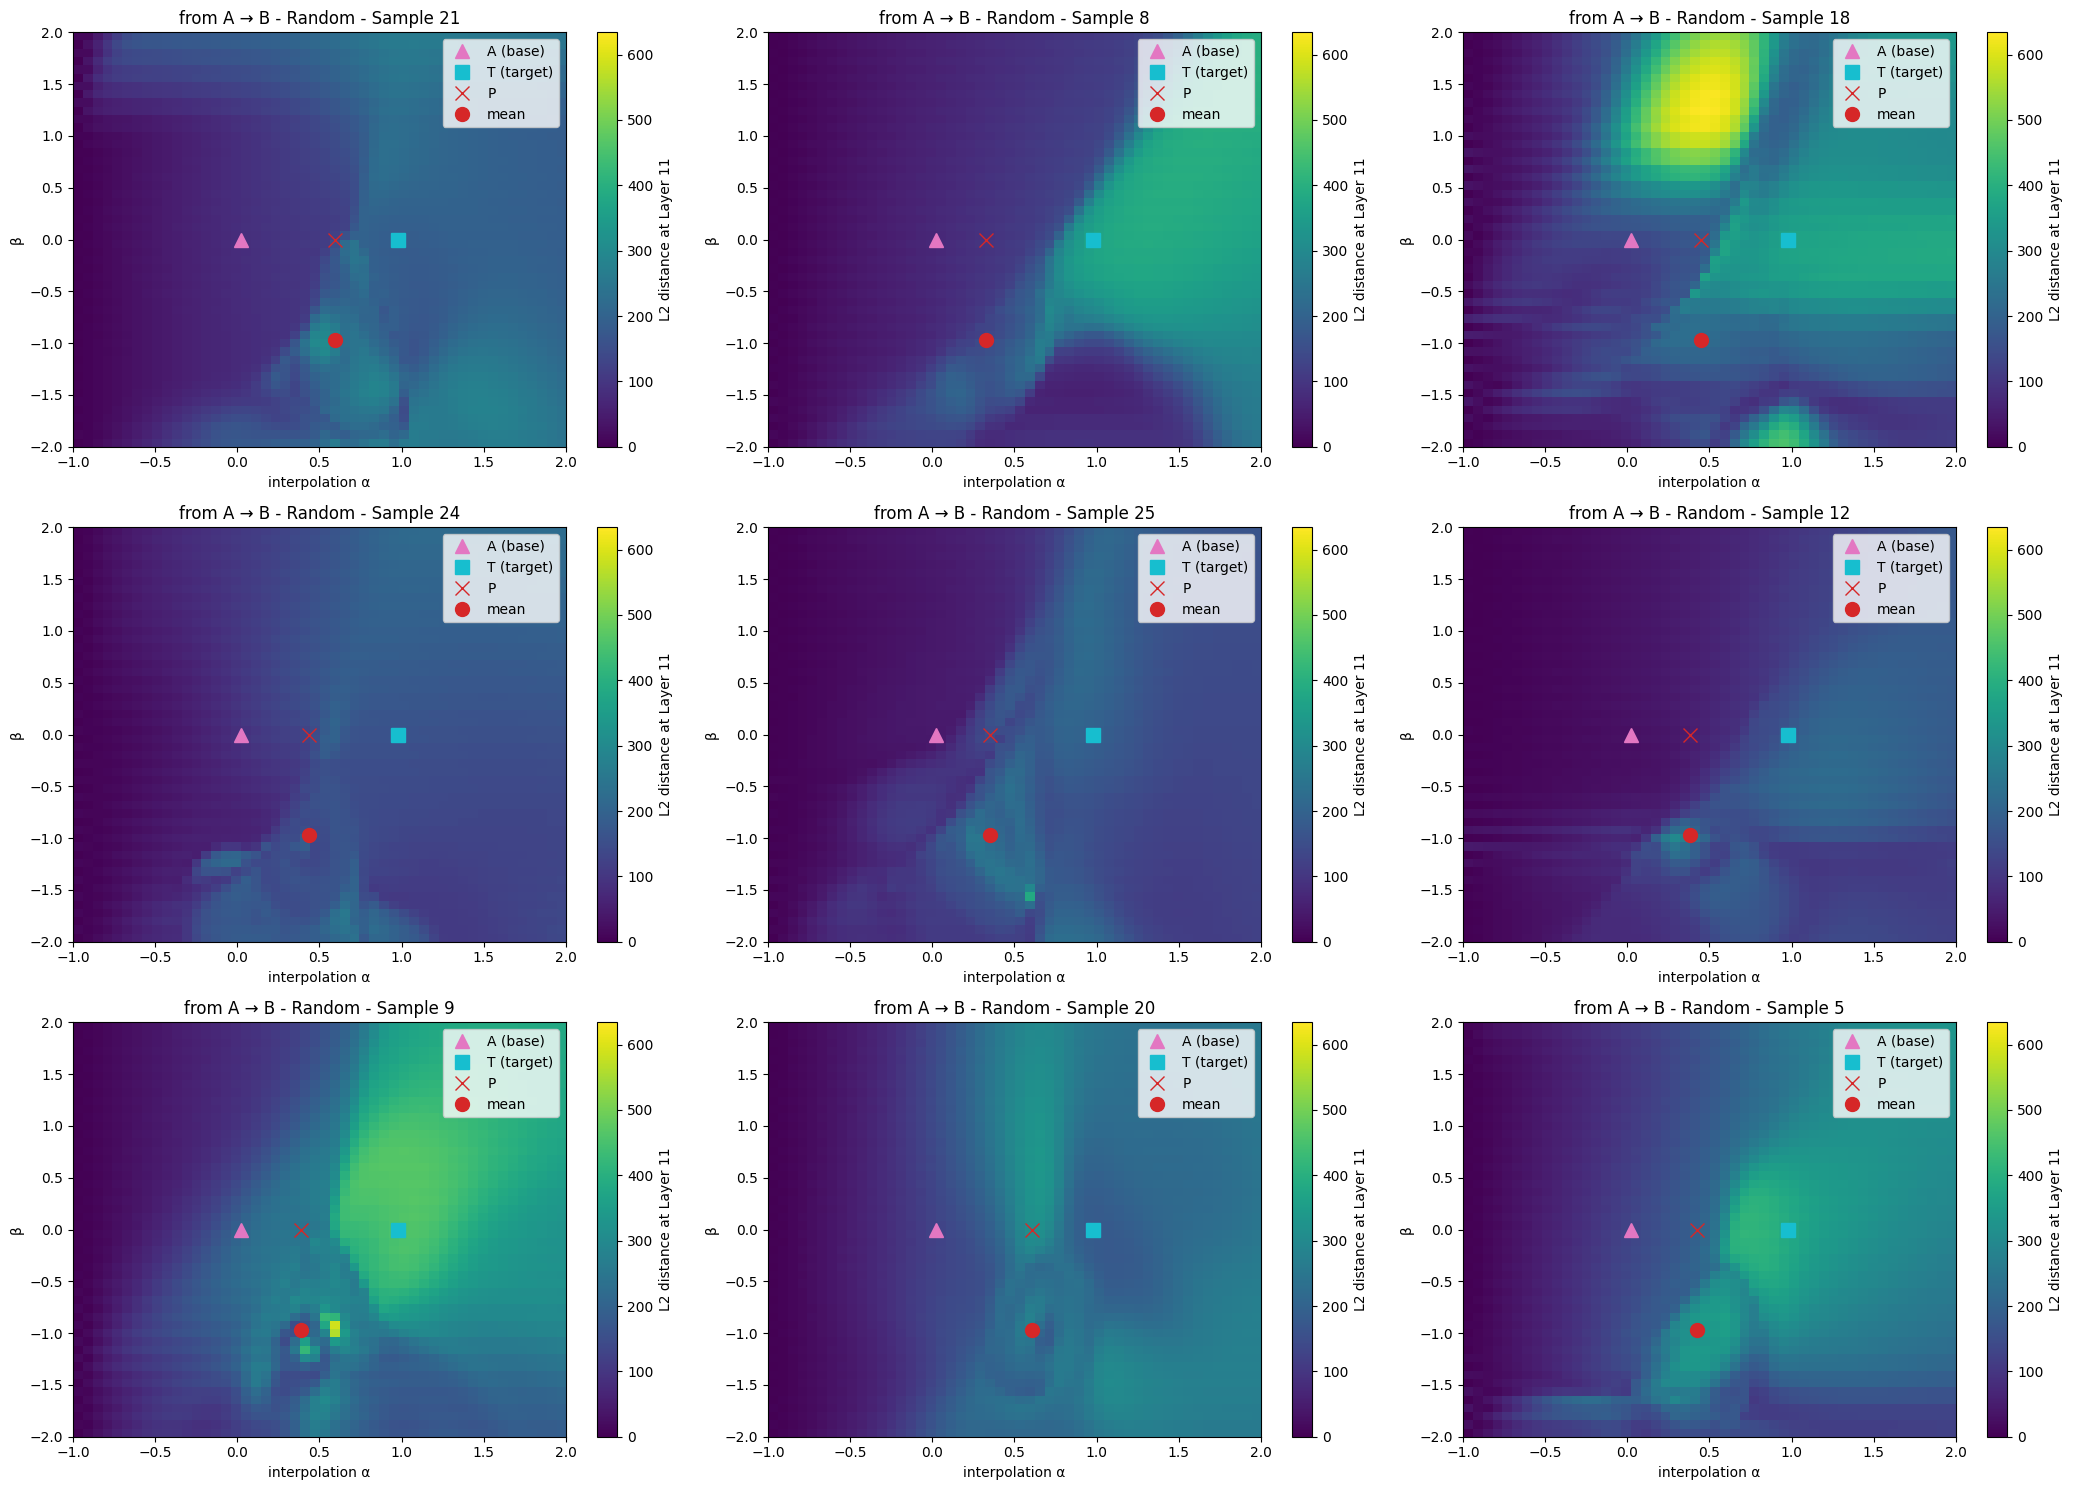

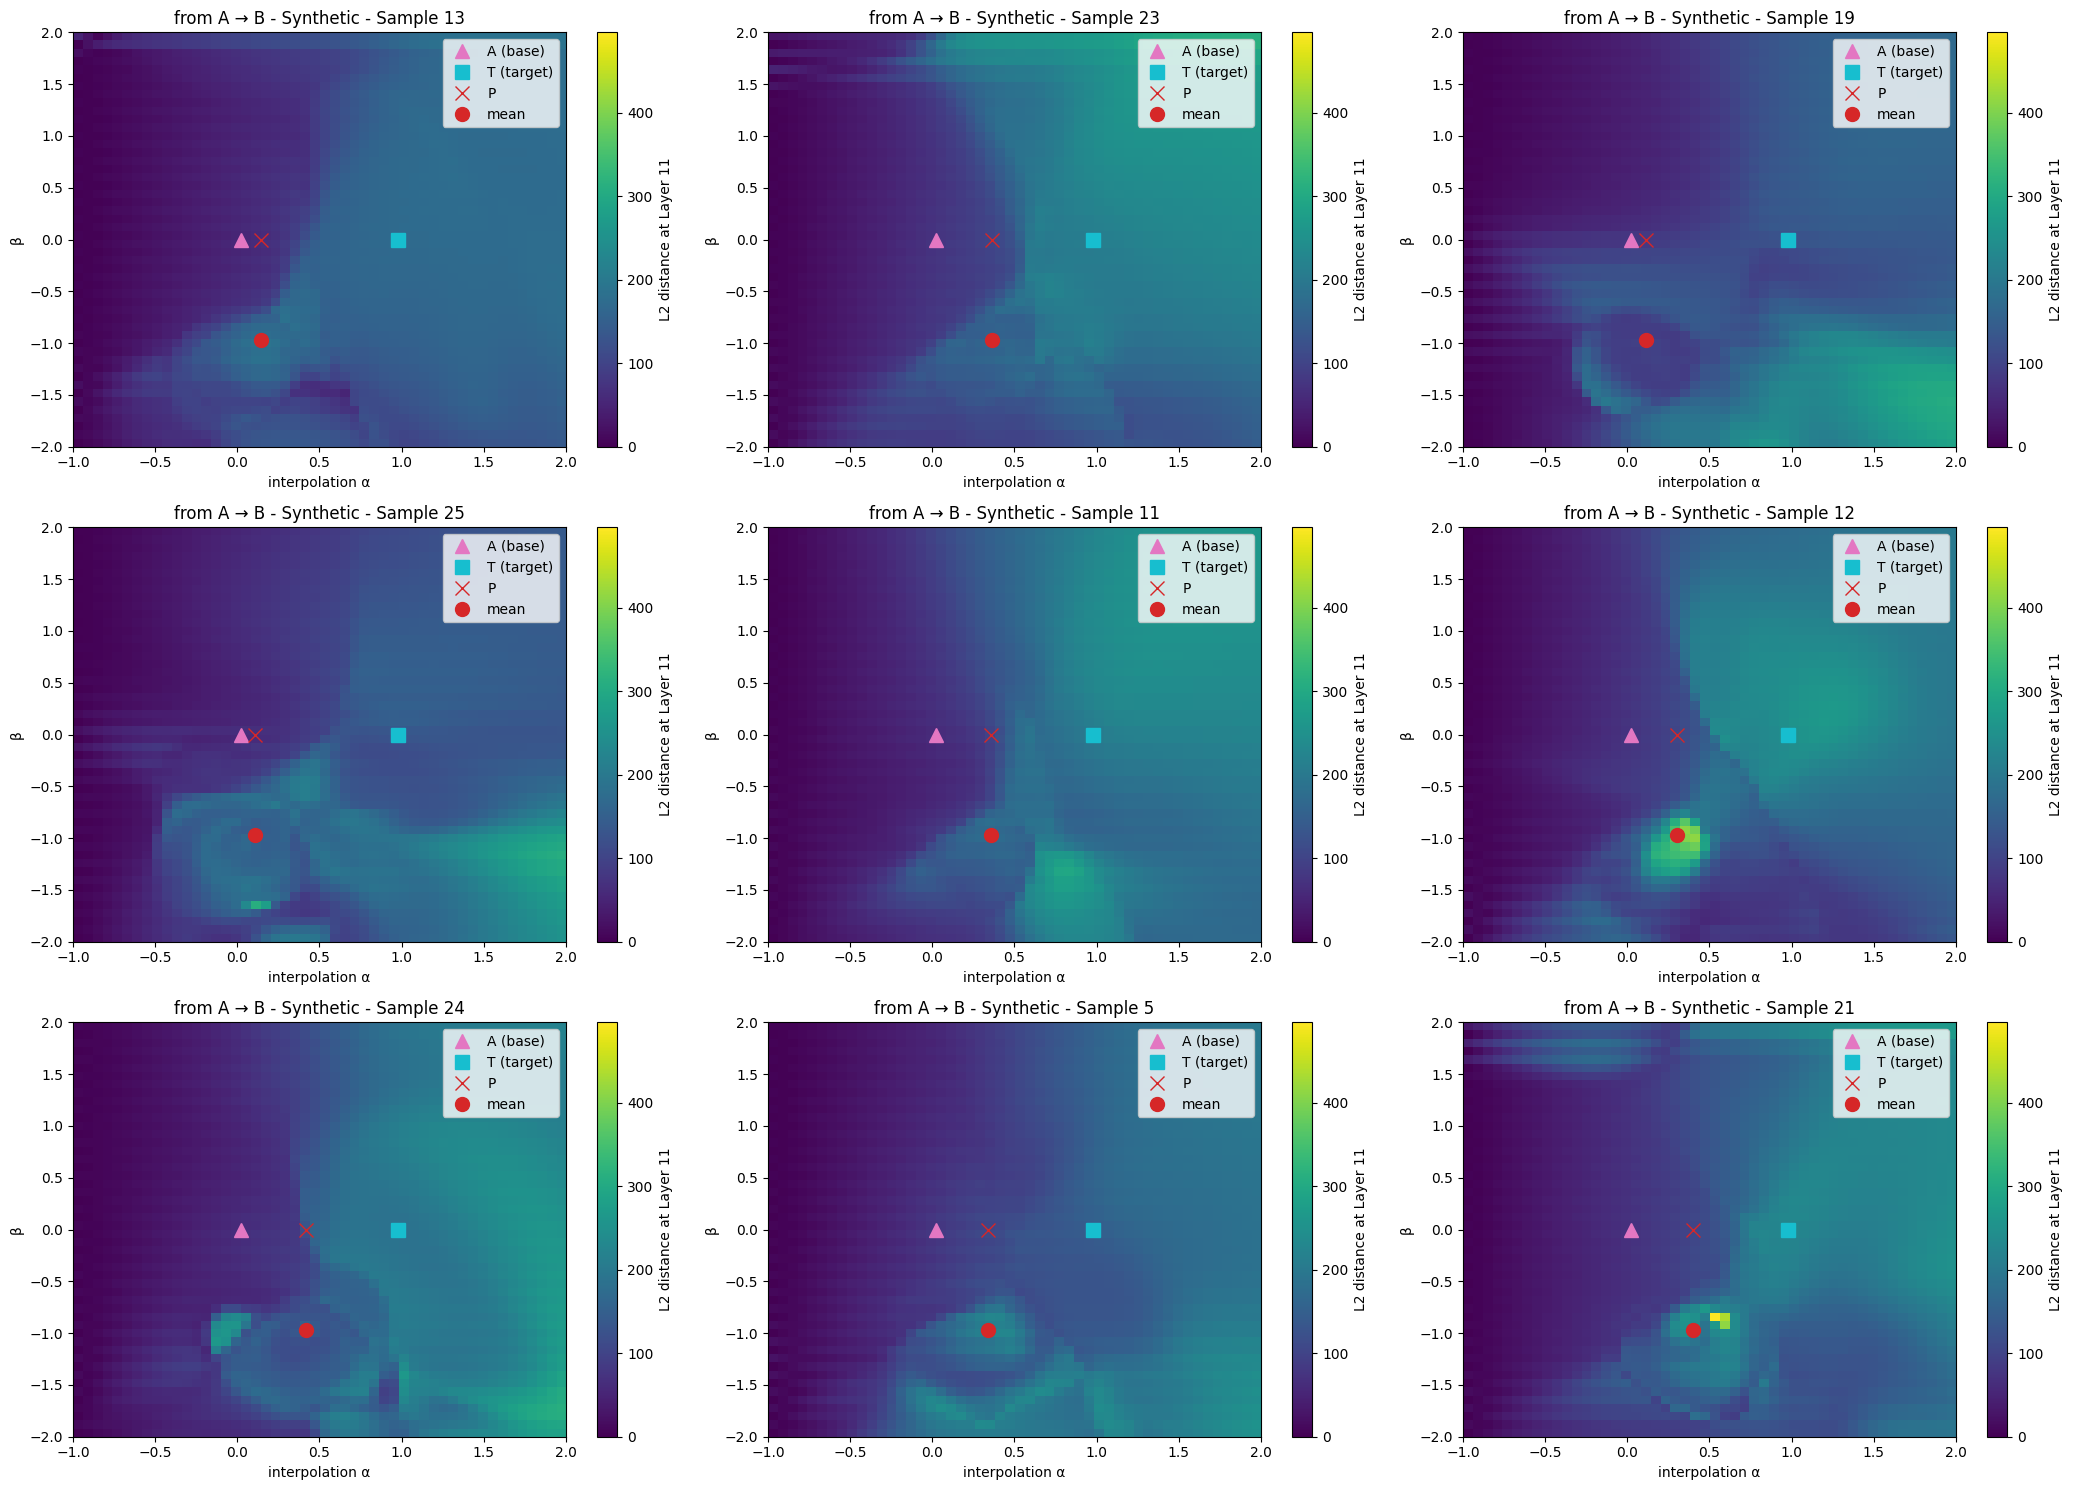

In [101]:
activation_types = [
    ("Other", all_other_acts),
    ("Random", all_random_acts),
    ("Synthetic", all_synth_acts),
]

for act_type, acts in activation_types:
    run_experiment(
        all_start_acts, acts, mean_act, act_type, n_alpha=50, n_beta=50, n_examples=9
    )